In [1]:
# ⚙️ Configuration
import os
import pandas as pd
from collections import defaultdict
import random

# Paths (update if needed)
dataset_root = os.path.expanduser(
    '~/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_'
    'alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/'
)
file_labels_csv = os.path.join(dataset_root, 'file_labels.csv')

# Aggregation settings
group_size = 500
agg_csv_out = agg_csv_out = os.path.join(
    dataset_root,
    f'file_labels_aggregated_g{group_size}.csv'
)

print(f"Dataset root: {dataset_root}")
print(f"Original labels CSV: {file_labels_csv}")
print(f"Aggregated CSV will be saved to: {agg_csv_out}")

Dataset root: /home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/
Original labels CSV: /home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/file_labels.csv
Aggregated CSV will be saved to: /home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/file_labels_aggregated_g500.csv


In [2]:
# 🧱 Build Aggregation CSV from file_labels.csv
# %% Cell 2: Build Aggregation CSV
df = pd.read_csv(file_labels_csv)

label_to_paths = defaultdict(list)
for _, row in df.iterrows():
    label = (row['energy_loss'], row['alpha'], row['q0'])
    label_to_paths[label].append(row['file_path'])

agg_entries = []
agg_id = 0
for label, paths in label_to_paths.items():
    random.shuffle(paths)
    for i in range(0, len(paths) - group_size + 1, group_size):
        group = paths[i:i + group_size]
        if len(group) == group_size:
            agg_entries.append({
                'agg_id': f'agg_{agg_id:06d}',
                'file_paths': '|'.join(group),
                'energy_loss': label[0],
                'alpha': label[1],
                'q0': label[2]
            })
            agg_id += 1

agg_df = pd.DataFrame(agg_entries)
agg_df.to_csv(agg_csv_out, index=False)
print(f"✅ Saved {len(agg_df)} aggregated entries to {agg_csv_out}")

✅ Saved 14399 aggregated entries to /home/arsalan/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/file_labels_aggregated_g500.csv


In [3]:
# 📦 Dataset Class with GPU Aggregation
# %% Cell 3: AggregatedJetDataset Definition
import torch
from torch.utils.data import Dataset
import numpy as np

class AggregatedJetDataset(Dataset):
    def __init__(self, agg_csv, root_dir, global_max, device='cuda'):
        self.df = pd.read_csv(agg_csv)
        self.root_dir = root_dir
        self.global_max = global_max
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_list = row['file_paths'].split('|')
        imgs = []
        for rel_path in file_list:
            abs_path = os.path.join(self.root_dir, rel_path)
            arr = np.load(abs_path).astype(np.float32) / self.global_max
            imgs.append(torch.tensor(arr, device=self.device).unsqueeze(0))
        img_avg = torch.stack(imgs).mean(dim=0).unsqueeze(0)
        labels = {
            'energy_loss_output': torch.tensor([row['energy_loss']], dtype=torch.long, device=self.device),
            'alpha_output':       torch.tensor([row['alpha']],       dtype=torch.long, device=self.device),
            'q0_output':          torch.tensor([row['q0']],          dtype=torch.long, device=self.device)
        }
        return img_avg, labels

In [4]:
# 📊 Stratified Split and DataLoader Builder
# %% Cell 4: Stratified Split & DataLoader Builder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def stratified_split(df, test_frac=0.1, val_frac=0.1, seed=42):
    y = df[['energy_loss','alpha','q0']].astype(str).agg('_'.join, axis=1)
    df_train, df_temp = train_test_split(df, test_size=test_frac+val_frac, stratify=y, random_state=seed)
    y_temp = df_temp[['energy_loss','alpha','q0']].astype(str).agg('_'.join, axis=1)
    df_val, df_test = train_test_split(df_temp,
                                       test_size=val_frac/(test_frac+val_frac),
                                       stratify=y_temp,
                                       random_state=seed)
    return df_train, df_val, df_test

In [5]:
def create_split_csvs(agg_csv: str,
    root_dir: str,
    test_frac: float = 0.1,
    val_frac: float = 0.1,
    seed: int = 42
) -> tuple[str, str, str]:
    # Read the aggregated CSV
    full_df = pd.read_csv(agg_csv)
    df_train, df_val, df_test = stratified_split(full_df,test_frac=test_frac, val_frac=val_frac, seed=seed)

    # Incorporate group_size into split filenames
    basename = os.path.splitext(os.path.basename(agg_csv))[0]  # e.g. "file_labels_aggregated_g5"
    train_csv = os.path.join(root_dir, f'{basename}_train.csv')
    val_csv   = os.path.join(root_dir, f'{basename}_val.csv')
    test_csv  = os.path.join(root_dir, f'{basename}_test.csv')

    # Save the splits
    df_train.to_csv(train_csv, index=False)
    df_val.to_csv(val_csv,     index=False)
    df_test.to_csv(test_csv,   index=False)
    return train_csv, val_csv, test_csv
def build_dataloaders_from_splits(
    train_csv: str,
    val_csv:   str,
    test_csv:  str,
    root_dir:  str,
    global_max: float,
    batch_size: int = 32
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Given filepaths to the train/val/test CSVs (generated by create_split_csvs),
    instantiate AggregatedJetDataset and return the three DataLoaders.
    """
    # Create Datasets
    train_ds = AggregatedJetDataset(train_csv, root_dir, global_max)
    val_ds   = AggregatedJetDataset(val_csv,   root_dir, global_max)
    test_ds  = AggregatedJetDataset(test_csv,  root_dir, global_max)

    # Build DataLoaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
# ✅ Test DataLoader Pipeline
# %% Cell 5: Quick Test

train_csv, val_csv, test_csv=create_split_csvs(
    agg_csv_out,
    dataset_root,
    test_frac=0.1,
    val_frac=0.1,
    seed=42
)
train_loader, val_loader, test_loader = build_dataloaders_from_splits(
    train_csv,
    val_csv,
    test_csv,
    dataset_root,
    global_max=121.79151153564453,
    batch_size=32
) 
x, y = next(iter(train_loader))
print("Batch images:", x.shape)
for k, v in y.items():
    print(f"{k}: {v.shape}")

Batch images: torch.Size([32, 1, 1, 32, 32])
energy_loss_output: torch.Size([32, 1])
alpha_output: torch.Size([32, 1])
q0_output: torch.Size([32, 1])


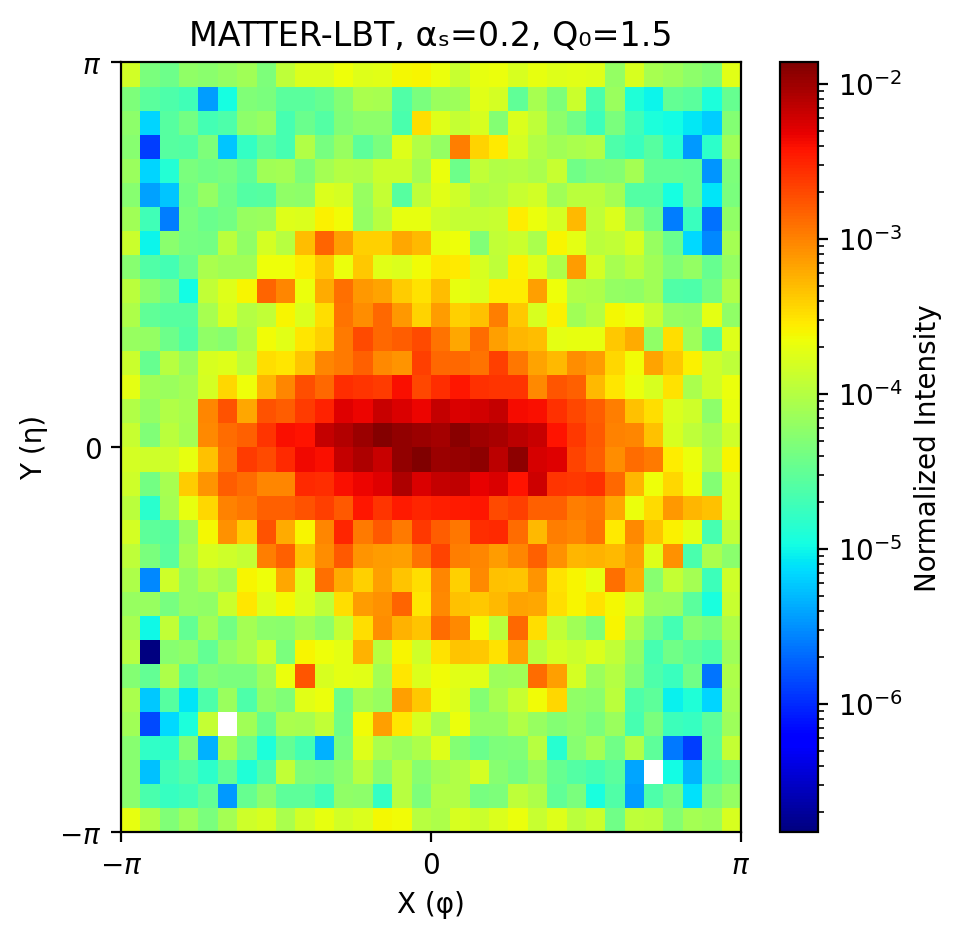

In [7]:
# %% Cell 6: Enhanced Single Plotter with Hist2D Style

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Maps for real parameter values
energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

# Fetch first batch sample (ensure x, y from Cell 5 are in scope)
img_tensor = x[0]                  # shape: (1,32,32)
img = img_tensor.squeeze()         # shape: (32,32)
if hasattr(img, 'cpu'):
    img = img.cpu().numpy()

# Extract true labels
energy_idx = y['energy_loss_output'][0].item()
alpha_idx  = y['alpha_output'][0].item()
q0_idx     = y['q0_output'][0].item()

# Human-readable labels
e_str = energy_map[energy_idx]
α = alpha_vals[alpha_idx]
Q0 = q0_vals[q0_idx]

# Mask zero pixels
img_masked = np.ma.masked_where(img == 0, img)

# Define bin edges for [-π, π]
x_edges = np.linspace(-math.pi, math.pi, img.shape[1] + 1)
y_edges = np.linspace(-math.pi, math.pi, img.shape[0] + 1)

# Plot
plt.figure(figsize=(5, 5), dpi=200)
pcm = plt.pcolormesh(
    x_edges, y_edges, img_masked,
    norm=colors.LogNorm(vmin=img_masked.min() or 1e-6, vmax=img_masked.max()),
    cmap='jet', shading='auto'
)
plt.colorbar(pcm, label='Normalized Intensity')
plt.title(f'{e_str}, αₛ={α}, Q₀={Q0}', fontsize=12)

# Shared axis ticks
plt.xticks([-math.pi, 0, math.pi], [r'$-\pi$', '0', r'$\pi$'])
plt.yticks([-math.pi, 0, math.pi], [r'$-\pi$', '0', r'$\pi$'])
plt.xlabel('X (φ)')
plt.ylabel('Y (η)')
plt.show()

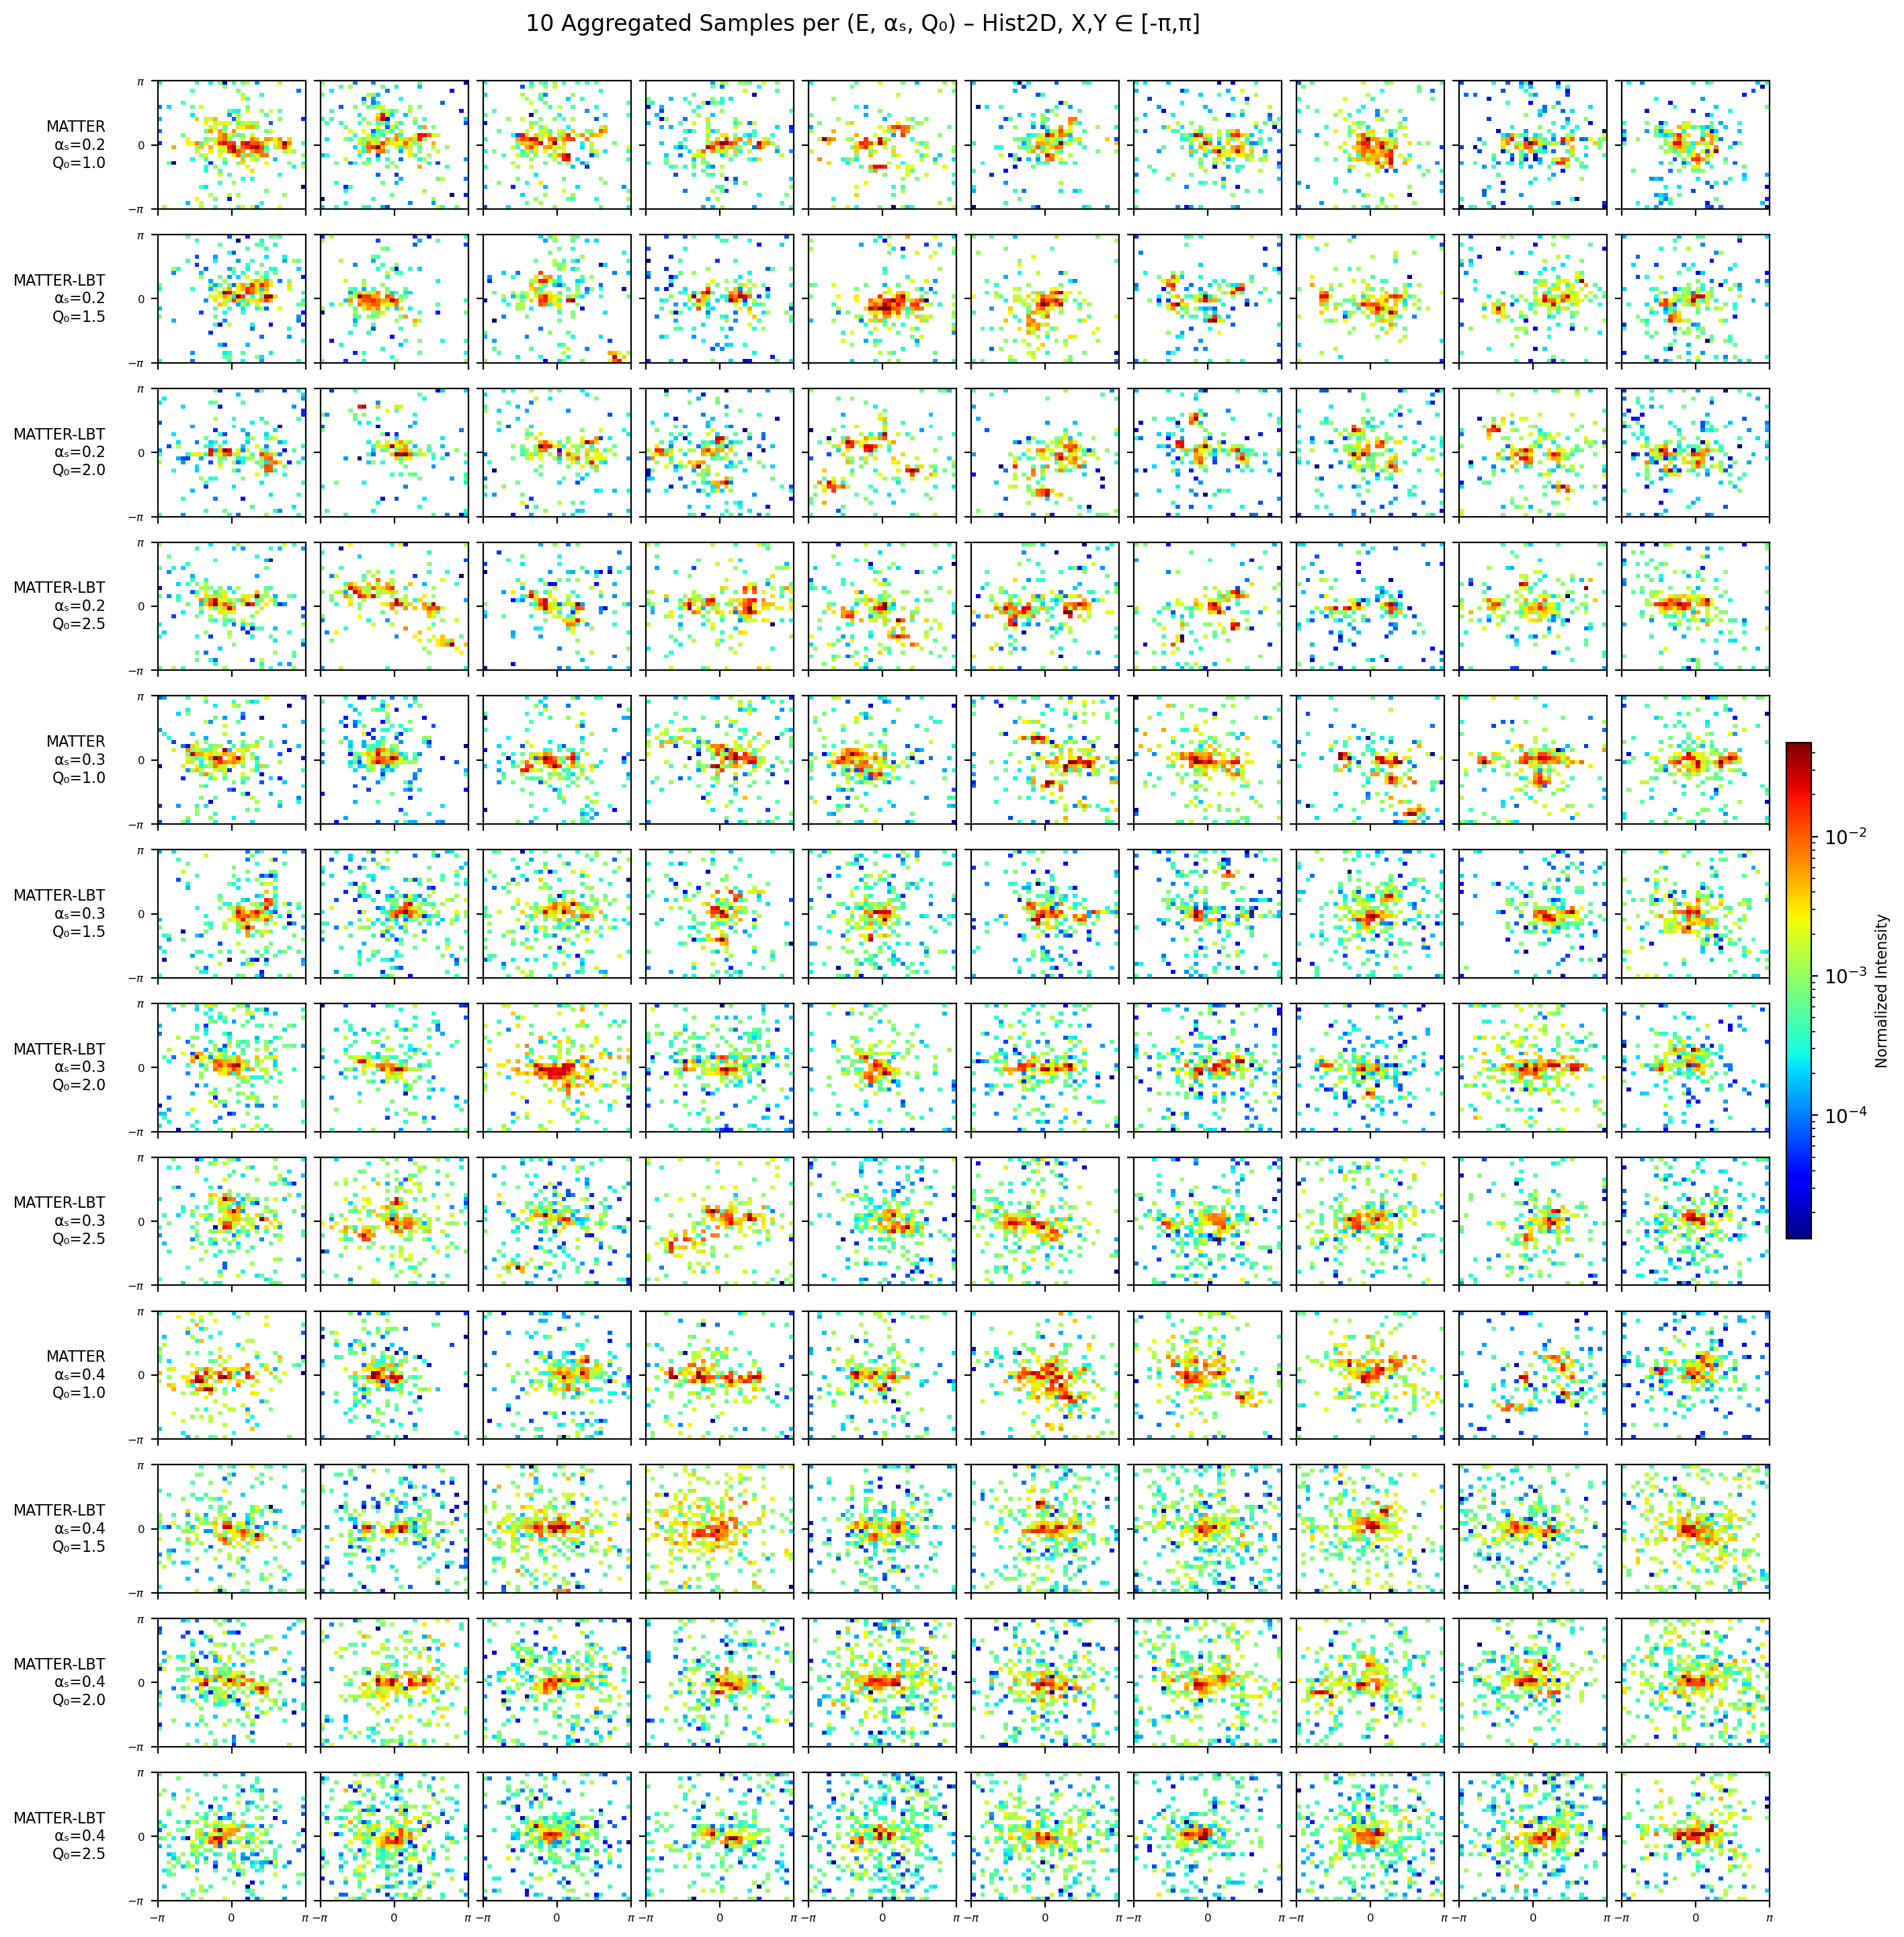

In [ ]:
# %% Cell 7: Grid of Hist2D Plots with Real Labels (12×10)

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import product

# Paths & constants
dataset_root = os.path.expanduser(
    '~/wsu-grid/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_'
    'alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled/'
)
agg_csv    = os.path.join(dataset_root, 'file_labels_aggregated_g500.csv')
global_max = 121.79151153564453

# Reverse‐maps for real values
energy_map = {0: 'MATTER', 1: 'MATTER-LBT'}
alpha_vals = {0: 0.2, 1: 0.3, 2: 0.4}
q0_vals    = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

# Load aggregated entries
df = pd.read_csv(agg_csv)

# All (alpha_idx, q0_idx) combos → 3×4 = 12 rows
combos = list(product([0,1,2], [0,1,2,3]))
n_rows, n_cols = len(combos), 10

# Create subplots
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols*1.5, n_rows*1.2),
    sharex='col', sharey='row',
    dpi=200
)

# Tight layout
fig.subplots_adjust(
    left   = 0.15,  # room for row labels
    right  = 0.97,
    top    = 0.96,
    bottom = 0.02,
    hspace = 0.2,
    wspace = 0.1
)

# Bin edges
x_edges = np.linspace(-math.pi, math.pi, 33)
y_edges = np.linspace(-math.pi, math.pi, 33)

for i, (a_idx, q_idx) in enumerate(combos):
    subset = df[(df['alpha']==a_idx) & (df['q0']==q_idx)]
    samples = subset.sample(n=n_cols, replace=len(subset)<n_cols, random_state=0)
    for j, (_, entry) in enumerate(samples.iterrows()):
        ax = axes[i, j]
        # Load & average
        imgs = [
            np.load(os.path.join(dataset_root, p)).astype(np.float32)/global_max
            for p in entry['file_paths'].split('|')
        ]
        avg = np.mean(imgs, axis=0)
        avg_masked = np.ma.masked_where(avg==0, avg)
        pcm = ax.pcolormesh(
            x_edges, y_edges, avg_masked,
            norm=colors.LogNorm(vmin=avg_masked.min() or 1e-6, vmax=avg_masked.max()),
            cmap='jet', shading='auto'
        )
        ax.set_xticks([]); ax.set_yticks([])
        # Real‐value row label
        if j == 0:
            e_str = energy_map[entry['energy_loss']]
            α = alpha_vals[a_idx]
            Q0 = q0_vals[q_idx]
            ax.text(-0.35, 0.5,
                    f'{e_str}\nαₛ={α}\nQ₀={Q0}',
                    transform=ax.transAxes,
                    va='center', ha='right',
                    fontsize=8)

# Shared ticks bottom row & left column
for ax in axes[-1, :]:
    ax.set_xticks([-math.pi, 0, math.pi])
    ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)
for ax in axes[:, 0]:
    ax.set_yticks([-math.pi, 0, math.pi])
    ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'], fontsize=6)

# Colorbar
cbar = fig.colorbar(pcm, ax=axes, fraction=0.015, pad=0.01)
cbar.set_label('Normalized Intensity', fontsize=8)

plt.suptitle('10 Aggregated Samples per (E, αₛ, Q₀) – Hist2D, X,Y ∈ [-π,π]', y=0.995, fontsize=12)
plt.show()
